In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import nltk
from nltk.stem.cistem import Cistem
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
import matplotlib.pyplot as plt
import seaborn
from textblob_de import TextBlobDE as TextBlob
import warnings
import h2o
from h2o.automl import H2OAutoML
import random 
import os
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
%matplotlib inline

In [2]:
# Raw data
train_data = pd.read_csv("/home/mackenzie/Downloads/GermanTrainingData.txt", sep='\t', names=['tweet', 'coarse', 'labels'])
test_data = pd.read_csv("/home/mackenzie/Downloads/GermanTestingData.txt", sep='\t', names=['tweet', 'coarse', 'labels'])
df = pd.concat([train_data, test_data], ignore_index=True)
del train_data
del test_data

In [3]:
tweets=df.tweet

# function to change accents for text processing purposes
def convert_umlauts(text):
    temp = text
    temp = temp.replace('ä', 'ae')
    temp = temp.replace('ö', 'oe')
    temp = temp.replace('ü', 'ue')
    temp = temp.replace('Ä', 'Ae')
    temp = temp.replace('Ö', 'Oe')
    temp = temp.replace('Ü', 'Ue')
    temp = temp.replace('ß', 'ss')
    return temp

# call the tweets below to change accented word to their roots
for i in range(0, len(tweets)):
    curr = tweets.iloc[i]
    tweets.iloc[i] = convert_umlauts(curr)

In [5]:
stopwords=stopwords = nltk.corpus.stopwords.words("german")

other_exclusions = ["lbr", "|lbr|", "»"]
stopwords.extend(other_exclusions)

stemmer = Cistem()

def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-ßA-ß]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-ßA-ß]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-ßA-ß.,!?]+", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=3000,
    min_df=5,
    max_df=0.75
    )

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/home/mackenzie/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['all', 'ber', 'dami', 'dasselb', 'demselb', 'denselb', 'derselb', 'dess', 'desselb', 'dieselb', 'dor', 'etwa', 'eur', 'f', 'geg', 'hatt', 'hrend', 'jed', 'jen', 'jetz', 'k', 'mach', 'manch', 'nich', 'nne', 'nnt', 'ohn', 'r', 'rde', 'selb', 'solch', 'son', 'sond', 'w', 'welch', 'werd', 'wes', 'woll', 'zwisch'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


{'^ml': 0, '`ne': 1, 'a': 2, 'a h': 3, 'ab': 4, 'ab heu': 5, 'abartig': 6, 'abend': 7, 'abgefuck': 8, 'abgefuck spd': 9, 'abgeleh': 10, 'abgeord': 11, 'abgeschaff': 12, 'abgeschob': 13, 'abgeschob werd': 14, 'abgeseh': 15, 'abgeseh davo': 16, 'abgewaehl': 17, 'abhaengig': 18, 'ableg': 19, 'ableh': 20, 'abschaff': 21, 'abschaffung': 22, 'abschaum': 23, 'abschieb': 24, 'abschiebung': 25, 'absehbar': 26, 'absich': 27, 'absolu': 28, 'abstimmung': 29, 'absurd': 30, 'abu': 31, 'abwaehl': 32, 'abwar': 33, 'abzug': 34, 'acc': 35, 'accou': 36, 'ach': 37, 'ach ja': 38, 'ach scheiss': 39, 'achtung': 40, 'adolf': 41, 'adv': 42, 'aegyp': 43, 'aehnlich': 44, 'ael': 45, 'aem': 46, 'aend': 47, 'aerg': 48, 'aerz': 49, 'aeuss': 50, 'aeusserung': 51, 'afd': 52, 'afd nich': 53, 'afd stimm': 54, 'afd waehl': 55, 'afdwuerg': 56, 'aff': 57, 'afghanista': 58, 'afri': 59, 'afrika': 60, 'agenda': 61, 'ah': 62, 'aha': 63, 'ahnung': 64, 'aksynod': 65, 'akt': 66, 'aktio': 67, 'aktuell': 68, 'akzeptier': 69, 'al': 

In [8]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-ßA-ß]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = TextBlob("tweet").sentiment
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words, lang='de_DE')
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    features = [FKRA, FRE, syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment[0],twitter_objs[2], twitter_objs[1], twitter_objs[0]]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

# Changing string labels to numeric labels
def string_to_numeric(x):
    if x == 'OTHER' or x == 'PROFANITY':
        return 0
    if x == 'INSULT':
        return 1
    if x == 'ABUSE':
        return 2

In [9]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "sentiment", "num_hashtags", "num_mentions", "num_urls"]

In [10]:
feats = get_feature_array(tweets)

In [11]:
#Now join them all up
M = np.concatenate([tfidf,feats],axis=1)

In [12]:
M.shape

(8407, 3013)

In [13]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

feature_names = variables+other_features_names

In [14]:
X = pd.DataFrame(M)
y = df['labels'].apply(string_to_numeric)
X.columns = feature_names

In [15]:
# Univariate feature selection from sklearn
bestfeatures = SelectKBest(score_func=f_classif, k=1000)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print('Univariate Selection features found, use getUnivariateData() to get the features')
# Extract the top n features
uni_selected_feat = featureScores.nlargest(1000,'Score')
print(uni_selected_feat) # print out the top n features selected

# Saving the top n features to a data frame
#print(a.iloc[0].name) # how to get the column # for the ith feature
#print(a.iloc[0][0]) # how to get the header column
top_univariate_features = pd.DataFrame()
for i in range(0, 1000):
    curr_column_vals = X.iloc[:, uni_selected_feat.iloc[i].name]
    curr_column_name = uni_selected_feat.iloc[i][0]
    top_univariate_features[curr_column_name] = curr_column_vals

X = pd.DataFrame(top_univariate_features)
X.columns = top_univariate_features.columns
print(X.columns)
feature_names = top_univariate_features.columns

/home/mackenzie/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [3009 3012] are constant.
  UserWarning)
/home/mackenzie/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Univariate Selection features found, use getUnivariateData() to get the features
                             Specs      Score
636                           dumm  64.461365
2473                    strunzdumm  55.880652
1749                          mosl  55.345552
2239                     schmarotz  53.819002
2000                          pack  52.935005
2001                     paedophil  52.840050
1687                        merkel  52.572181
1251                       invasor  49.851795
1265                         islam  48.541379
198                          asyla  47.059928
1763                       murksel  45.142919
1596                   luegenpress  43.138647
2648                        vasall  41.965389
2219                       scheiss  41.374236
2267                schulabschluss  38.508092
818                         fettig  34.680448
819                    fettig haar  34.563703
2240           schmarotz paedophil  34.354193
2270                        schulz  33.965406

In [16]:
print(len(X))
print(len(y))

8407
8407


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [18]:
y_train = y_train.to_frame(name='labels')
y_test = y_test.to_frame(name='labels')

In [19]:
# Undersampling from imblearn
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_res)
X_train.columns = feature_names
y_train = pd.DataFrame(y_res)
y_train.columns = ['labels']

In [20]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.2" 2019-01-15 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.2+9-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.2+9-LTS, mixed mode)
  Starting server from /home/mackenzie/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpb5s6dwsw
  JVM stdout: /tmp/tmpb5s6dwsw/h2o_mackenzie_started_from_python.out
  JVM stderr: /tmp/tmpb5s6dwsw/h2o_mackenzie_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Vienna
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.1
H2O cluster version age:,20 days
H2O cluster name:,H2O_from_python_mackenzie_z7e5zs
H2O cluster total nodes:,1
H2O cluster free memory:,1.922 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [21]:
# BUG: when we convert to h2o dataframe an extra row is added
X_train = h2o.H2OFrame(X_train)
y_train = h2o.H2OFrame(y_train)
X_test = h2o.H2OFrame(X_test)
y_test = h2o.H2OFrame(y_test) 

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [22]:
X_train = X_train.na_omit() # pandas-->h2o results in an error where a nan row is added to X data, so this deals with that
X_test = X_test.na_omit()

In [23]:
# Double check X and y have same number of rows
print(len(y_train))
print(len(X_train))
print(len(y_test))
print(len(X_test))

2610
2610
841
841


In [24]:
X_train.shape

(2610, 1000)

In [25]:
# preparing the train and test data sets
# now convert tweet vecs and labels to a pandas dataframe and back to h2o dataframe
train = X_train.cbind(y_train)
test = X_test.cbind(y_test)

In [26]:
# more on data prep
x = train.columns         # x: A list/vector of predictor column names or indexes. 
                          # This argument only needs to be specified if the user wants to exclude columns from the 
                          # set of predictors. If all columns (other than the response) should be used in prediction, 
                          # then this does not need to be set.

y = "labels"              # This argument is the name (or index) of the response column
x.remove(y)

# need to set train and test
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [27]:
# now the AUTO-ML piece comes in
aml = H2OAutoML(max_runtime_secs=1800) #sort_metric=auc, max_runtime_secs=10800, class_sampling_factors = sample_factors, max_models=?, balance_classes=True
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [28]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)
lb_pd = lb.as_data_frame()

In [29]:
# The leader model is stored here
aml.leader

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190805_150218_model_1

GLM Model: summary



,family,link,regularization,lambda_search,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
,multinomial,multinomial,Ridge ( lambda = 6.6768 ),"nlambda = 30, lambda.max = 6.6768, lambda.min = 6.6768, lambda.1se = 6.6768",2916,2892,2,automl_training_py_3_sid_a0ef




ModelMetricsMultinomialGLM: glm
** Reported on train data. **

MSE: 0.4074572415737435
RMSE: 0.6383237748774078

ModelMetricsMultinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.4225374959814697
RMSE: 0.6500288424227572
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.6272030,0.0176536,0.6302682,0.6034483,0.6704981,0.6015326,0.6302682
err,0.3727969,0.0176536,0.3697318,0.3965517,0.3295019,0.3984674,0.3697318
err_count,194.6,9.215205,193.0,207.0,172.0,208.0,193.0
logloss,1.0511941,0.0011040,1.0531588,1.0526212,1.0497366,1.0512986,1.0491554
max_per_class_error,0.4321839,0.0161330,0.4425287,0.4137931,0.4080460,0.4712644,0.4252874
mean_per_class_accuracy,0.6272030,0.0176536,0.6302682,0.6034483,0.6704981,0.6015326,0.6302682
mean_per_class_error,0.3727969,0.0176536,0.3697318,0.3965517,0.3295019,0.3984674,0.3697318
mse,0.4225375,0.0005126,0.4234273,0.4232222,0.4218513,0.4225942,0.4215924
null_deviance,1146.9512,0.0,1146.9512,1146.9512,1146.9512,1146.9512,1146.9512
r2,0.3661937,0.0007689,0.364859,0.3651667,0.3672230,0.3661087,0.3676114


Scoring History: 


,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test,deviance_xval,deviance_se
,2019-08-05 15:05:26,0.000 sec,2,.67E1,2895,2.0370352,nan,0.0,0.0


In [30]:
# predictions!
preds = aml.predict(test)
print(preds)
var = preds["predict"].cbind(test[y])
print(var)

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1,p2
0,0.356166,0.335375,0.308459
1,0.30859,0.369759,0.321651
1,0.261691,0.497316,0.240993
0,0.350252,0.329928,0.31982
1,0.328492,0.346748,0.32476
0,0.343181,0.329798,0.327021
0,0.365628,0.320253,0.314119
0,0.345811,0.329315,0.324874
2,0.322275,0.33437,0.343355
2,0.315781,0.319757,0.364463


predict,labels
0,0
1,1
1,1
0,0
1,1
0,0
0,0
0,0
2,1
2,2


In [31]:
# Create a new folder to hold statistics for a run
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

# create a random folder number to reference the directory
rand = random.randint(0, 1000)
directory = '/home/mackenzie/workspace/PycharmProjects/DAADRISE_AbusiveLangProject/Results_Aug5/TestFeatureSelUnd_' + str(rand)
print('The results for this run will be stored in ' + directory)
createFolder(directory)

The results for this run will be stored in /home/mackenzie/workspace/PycharmProjects/DAADRISE_AbusiveLangProject/Results_Aug5/TestFeatureSelUnd_547


Confusion Matrix: 
[[417  85  85]
 [ 24  49  20]
 [ 33  25 103]]
Accuracy Score: 
0.6765755053507729
F1 Score: 
0.6985247337257096
Recall: 


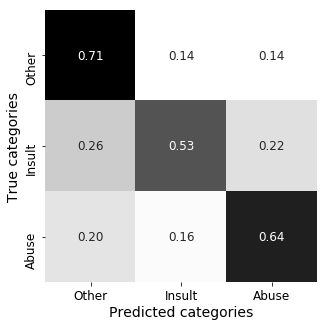

In [32]:
# metrics and results!
y_test = h2o.as_list(test[y], use_pandas=True)
y_pred = h2o.as_list(preds["predict"])
print("Confusion Matrix: ")
print(metrics.confusion_matrix(y_test, y_pred))
print("Accuracy Score: ")
print(metrics.accuracy_score(y_test, y_pred))
print("F1 Score: ")
print(metrics.f1_score(y_test, y_pred, average="weighted"))
print("Recall: ")
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Other','Insult','Abuse']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig(directory + '/recall.png')

In [33]:
# Saves the classification report info
print(metrics.classification_report(y_test, y_pred))
f= open(directory+'/classification_report.txt',"w+")
f.write(metrics.classification_report(y_test, y_pred))
f.write(str(metrics.confusion_matrix(y_test,y_pred)))
f.write('\n')
f.write('accuracy: '+ str(metrics.accuracy_score(y_test, y_pred)))
f.write('\n')
f.write('f1-score' + str(metrics.f1_score(y_test, y_pred, average="weighted")))
f.write('\n')
f.close()

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       587
           1       0.31      0.53      0.39        93
           2       0.50      0.64      0.56       161

    accuracy                           0.68       841
   macro avg       0.56      0.63      0.58       841
weighted avg       0.74      0.68      0.70       841



In [34]:
file = lb_pd.to_csv(path_or_buf=directory+'/modelinfo.csv')
featuresSelected = uni_selected_feat.to_csv(path_or_buf=directory+'/feature_selection.csv')